<img src="random_brain.jpg" width="350" height="300" align="right"/>

# Bagging: Random Forest Ensemble

Author: Christoph Güttner


**Abstract:**A Random Forest Ensemble is used here to analyse five real world  
datasets. A short theory overview presents the idea of ensemble learning. The  
analysis shows how the number of classifier affects the train and test scores.  
    
The Random Forest Algorithm has three relevant hyper-parameters: n_estimator,  
max_depth and max_feature. These are set here to  n_estimator between $1-100$,  
max_depth to 2 and max_feature=$\sqrt{d}$, where n_estimator denots the  
number of trees in the ensemble, max_depth the number of splits    
and d the number of features in the dataset. In case of classification  
the criterion for information gain also matters and is set to 'enthropie'.


## Table of Contents
* [Loading and Preprocessing](#Loading_and_Preprocessing)
    * [Imports](#Imports)
    * [Functions](#Functions)

* [Theory Overview](#Time_Series_Data)
    * [Bias Variance Decomposition](#Bias_Variance_Decomposition)
    * [Bootstrapping Aggregation](#Bootstrapping_Aggregation)
* [Real Data](#Real_Data)
    * [Diamonds](#Diamonds)
    * [Planets](#Planets)
    * [Titanic](#Titanic)
    * [Wine](#Wine)
    * [Digits](#Digits)


In [157]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_wine, load_digits




In [172]:

def load_data(data, target_col):
    if isinstance(data, pd.DataFrame): 
        X = data.drop(target_col, axis = 1)
        y = data[target_col].to_numpy()
    elif isinstance(data.data, np.ndarray):
        X = data.data
        y = data.target
    else:
        return 'Type Error'
    return X,y


def make_dictionary(dataset):
    features = {dataset.feature_names[i] : dataset.data[:,i] for i in range(len(dataset.feature_names))}
    target = {'target' : dataset.target}
    return features, target

def get_dataframe(features, target):
    df = pd.DataFrame(features)
    df = df.assign(**target)
    return df

def encoder(X):
    if isinstance(X, pd.DataFrame):
        encoder = LabelEncoder()
        to_encode = X.select_dtypes(exclude = 'float').columns.values
        X[list(to_encode)] = X[to_encode].apply(encoder.fit_transform)
    else:
        return X
    return X

def scalar(X):
    scalar = StandardScaler()
    X = scalar.fit_transform(X)
    return X

def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    return X_train, X_test, y_train, y_test

def random_forest_classification(X_train, X_test, y_train, y_test):
    num_esti = list(range(100))
    Score_train=[]
    Score_test=[]
    for i in range(1,len(num_esti)):
        classifier = RandomForestClassifier(n_estimators = num_esti[i] , max_depth=2, max_features="sqrt", criterion =                                                                                              'entropy',random_state = 0)
        classifier.fit(X_train,y_train)
        y_pred= classifier.predict(X_test)
        score_train = classifier.score(X_train,y_train)
        score_test = classifier.score(X_test,y_test)
        Score_train.append(score_train)
        Score_test.append(score_test)
    return Score_train, Score_test

def random_forest_regression(X_train, X_test, y_train, y_test):
    num_esti = list(range(100))
    Score_train=[]
    Score_test=[]
    for i in range(1,len(num_esti)):
        classifier = RandomForestRegressor(n_estimators = num_esti[i] , max_depth=2, max_features="sqrt",random_state = 0)
        classifier.fit(X_train,y_train)
        y_pred= classifier.predict(X_test)
        score_train = classifier.score(X_train,y_train)
        score_test = classifier.score(X_test,y_test)
        Score_train.append(score_train)
        Score_test.append(score_test)
    return Score_train, Score_test


def plot_scores(Score_train, Score_test):
    plt.figure(figsize=(15,5))
    plt.plot(Score_train, label='train')
    plt.plot(Score_test, label='test')
    plt.title(title, fontdict = {'fontsize' : 25})
    plt.xlabel('N_Estimator',fontdict = {'fontsize' : 15})
    plt.ylabel('Score', fontdict = {'fontsize' : 15})
    plt.legend()

## Theory: Random Forest Ensemble  
  
### Bias Variance Decomposition of Expected Test Error  
  
We start here with a short introduction to bias variance decomposition. Here, not only  
the input data is considered as a random variable, but also the resulting parameter  
of classifieres $h$ present a random variable. Hence, the $h$ also posseses a mean  
and variance, when it is applied multiple times on different subsets of the same  
trainings data D.  In other words, D  itself is drawn from $P_n$, and is therefore  
a random variable. Further, $h_D$ is a function of D, and is therefore also a  
random variable:


**Mean:**  The mean $\bar{h}$ results from all possible subsets D over $P_n$.  
  
  $\begin{equation*}
  \bar{h} = \int\limits_{D} h_{D} \Pr(D) dD
  \end{equation*}$  
    
**Bias:** The bias captures how far the predicted value h(x) is from the true  
value y(x) (even with an infinite amount of  training data)
    
  $\bar{h}(\mathbf{x}) - \bar{y}(\mathbf{x})$
  
**Variance:** The variance captures how much your classifier  
changes if you train on a different training set. 

  $[h_D(x)-\bar{h}(x)]^2$

**Test Error:** We can now decompose the mean squared error of the test data as follows.
<br/><br/> 
  
 $\begin{equation*}
    \underbrace{\mathbb{E}[(h_D(x) - y)^2]}_\mathrm{Error} = \underbrace{\mathbb{E}[(h_D(x)-\bar{h}(x))^2]}_\mathrm{Variance} + \underbrace{\mathbb{E}[(\bar{h}(x)-\bar{y}(x))^2]}_\mathrm{Bias} + \underbrace{\mathbb{E}[(\bar{y}(x)-y(x))^2]}_\mathrm{Noise}
\end{equation*}$,  
  
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

### Bagging (Bootstrap Aggregating) with the Random Forest Ensemble  
  
Bagging in general and the random forest algorithm in particular are a techniques  
to reduce variance. More concrete, the error term of bias variance decomposition,  
which is caused by variance can be averaged out by an ensemble of classifiern.  
Assume we have m training sets $D_1,D_2,...,D_n$ drawn from $P_n$ by drawing  
uniformly with replacement from the set D (Bootstrap Aggregating). 

$\hat{h} = \frac{1}{m}\sum_{i = 1}^m h_{D_i} \to \bar{h} \qquad as\  m \to \infty$  
  
We refer to such an average of multiple classifiers as an **Ensemble**.

source: http://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/


## Load Datasets

In [173]:
diamonds = sns.load_dataset('diamonds')
planets = sns.load_dataset('planets')
titanic= sns.load_dataset('titanic')
wine = load_wine()
digits = load_digits()


## Diamonds

In [174]:
diamonds.tail()

,carat,cut,color,clarity,depth,table,price,x,y,z
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74
53939,0.75,Ideal,D,SI2,62.2,55.0,2757,5.83,5.87,3.64


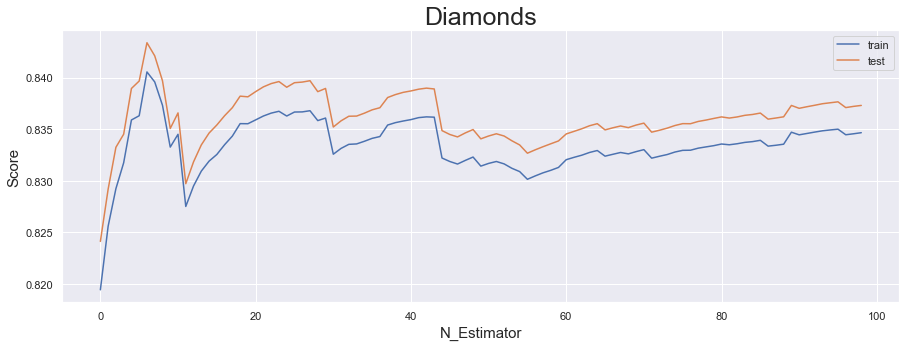

In [175]:
title='Diamonds'
X,y = load_data(diamonds,'price')
X_en = encoder(X)
X_sc = scalar(X_en)
X_train, X_test, y_train, y_test = split(X_sc,y)
Score_train, Score_test = random_forest_regression(X_train, X_test, y_train, y_test)
plot_scores(Score_train, Score_test)

## Planets

In [176]:
planets = planets.dropna()
planets.tail()

,method,number,orbital_period,mass,distance,year
640,Radial Velocity,1,111.70000,2.100,14.90,2009
641,Radial Velocity,1,5.05050,1.068,44.46,2013
642,Radial Velocity,1,311.28800,1.940,17.24,1999
649,Transit,1,2.70339,1.470,178.00,2013
784,Radial Velocity,3,580.00000,0.947,135.00,2012


In [194]:
planets.method.unique()

array(['Radial Velocity', 'Transit'], dtype=object)

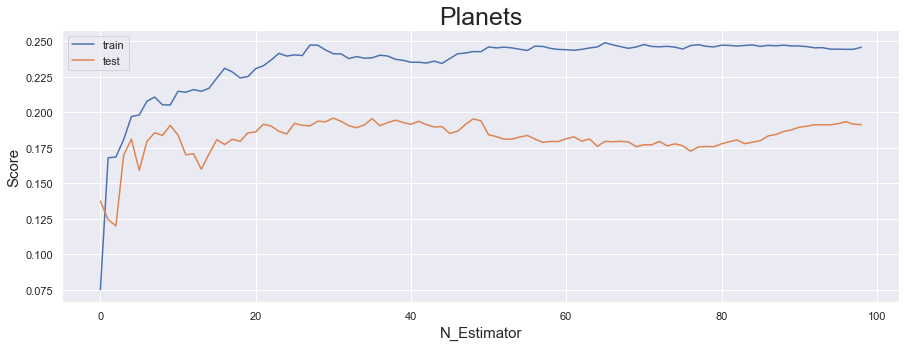

In [193]:
title='Planets'
X,y = load_data(planets,'distance')
X_en = encoder(X)
X_sc = scalar(X_en)
X_train, X_test, y_train, y_test = split(X_sc,y)
#Score_train, Score_test = random_forest_classification(X_train, X_test, y_train, y_test)
Score_train, Score_test = random_forest_regression(X_train, X_test, y_train, y_test)
plot_scores(Score_train, Score_test)

## Titanic

In [179]:
titanic = titanic.drop('deck',axis=1)
titanic = titanic.dropna()
titanic.tail()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone
885,0,3,female,39.0,0,5,29.125,Q,Third,woman,False,Queenstown,no,False
886,0,2,male,27.0,0,0,13.000,S,Second,man,True,Southampton,no,True
887,1,1,female,19.0,0,0,30.000,S,First,woman,False,Southampton,yes,True
889,1,1,male,26.0,0,0,30.000,C,First,man,True,Cherbourg,yes,True
890,0,3,male,32.0,0,0,7.750,Q,Third,man,True,Queenstown,no,True


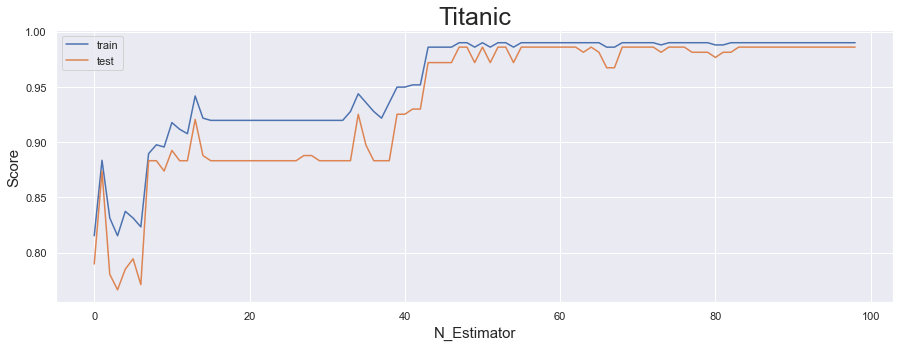

In [180]:

title='Titanic'
X,y = load_data(titanic,'survived')
X_en = encoder(X)
X_sc = scalar(X_en)
X_train, X_test, y_train, y_test = split(X_sc,y)
Score_train, Score_test = random_forest_classification(X_train, X_test, y_train, y_test)
plot_scores(Score_train, Score_test)

## Wine

In [181]:
features, target =  make_dictionary(wine)
df_wine = get_dataframe(features, target)
df_wine.tail()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840.0,2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560.0,2


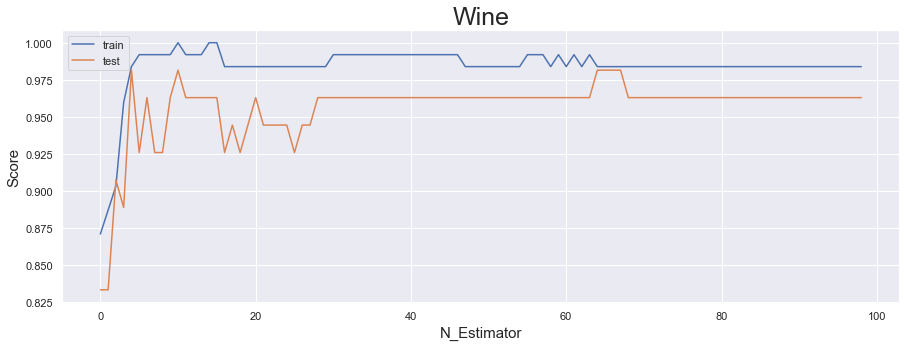

In [182]:
title='Wine'
X,y = load_data(wine,'price')
X_en = encoder(X)
X_sc = scalar(X_en)
X_train, X_test, y_train, y_test = split(X_sc,y)

Score_train, Score_test = random_forest_classification(X_train, X_test, y_train, y_test)
plot_scores(Score_train, Score_test)

## Digits

In [183]:
features, target =  make_dictionary(digits)
df_wine = get_dataframe(features, target)
df_wine.tail()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0,9
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0,0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0,8
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0,9
1796,0.0,0.0,10.0,14.0,8.0,1.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,8.0,12.0,14.0,12.0,1.0,0.0,8


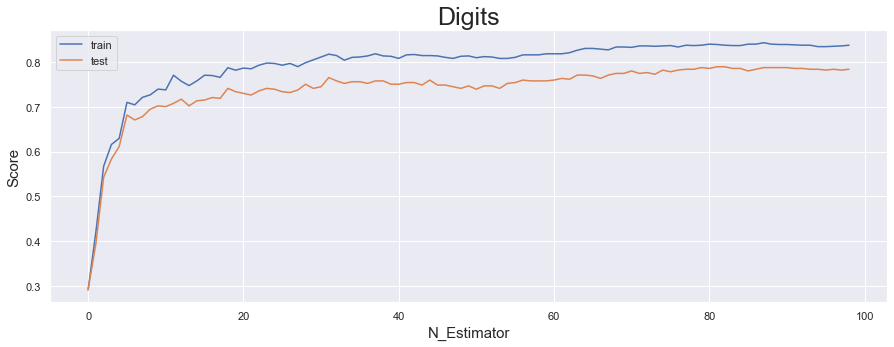

In [184]:
title='Digits'
X,y = load_data(digits,'non')
X_en = encoder(X)
X_sc = scalar(X_en)
X_train, X_test, y_train, y_test = split(X_sc,y)

Score_train, Score_test = random_forest_classification(X_train, X_test, y_train, y_test)
plot_scores(Score_train, Score_test)